# 微积分
 为了求出曲线形状（比如圆）的面积，古希腊人在这样的形状上刻内接多边形。 为了求出曲线形状（比如圆）的面积，古希腊人在这样的形状上刻内接多边形。事实上，逼近法就是积分（integral calculus）的起源， 我们将在*sec_integral_calculus*中详细描述。 2000多年后，微积分的另一支，微分（$differential$ $calculus$）被发明出来。最终，我们真正关心的是生成一个模型，它能够在从未见过的数据上表现良好。 但“训练”模型只能将模型与我们实际能看到的数据相拟合。 因此，我们可以将拟合模型的任务分解为两个关键问题：
* **优化（optimization）**：用模型拟合观测数据的过程；

* **泛化（generalization）**：数学原理和实践者的智慧，能够指导我们生成出有效性超出用于训练的数据集本身的模型。

## 2.5 自动微分
求导是几乎所有深度学习优化算法的关键步骤。深度学习框架通过自动计算导数，即**自动微分automatic differentiation**来加快求导。 实际中，根据我们设计的模型，系统会构建一个**计算图computational graph**， 来跟踪计算是哪些数据通过哪些操作组合起来产生输出。 自动微分使系统能够随后反向传播梯度。 这里，**反向传播backpropagate**意味着跟踪整个计算图，填充关于每个参数的偏导数。

---
例如求解$y=2x^Tx$对$x$的导数

In [4]:
import torch
x = torch.tensor([2.0, 4, 3, 1])
x

tensor([2., 4., 3., 1.])

在我们计算关于的梯度之前，我们**需要一个地方来存储梯度**。 重要的是，我们不会在每次对一个参数求导时都分配新的内存。 因为我们经常会成千上万次地更新相同的参数，每次都分配新的内存可能很快就会将内存耗尽。

In [7]:
x.requires_grad_(True) # 等价于 x = torch.tensor([2, 4, 3, 1], requires_grad=True)
x.grad # 默认为None

In [9]:
y = 2*torch.dot(x, x)
y.backward()  # 意思是调用反向传播，计算y对x的每一个分量的导数
x, y, x.grad, x.grad==4*x # y' = 4x

(tensor([2., 4., 3., 1.], requires_grad=True),
 tensor(60., grad_fn=<MulBackward0>),
 tensor([ 8., 16., 12.,  4.]),
 tensor([True, True, True, True]))

In [11]:
# 在计算其他函数对x的微分时，由于grad是默认累积的，故应该清零
x.grad.zero_()
y = torch.sum(x)  # dy/dx_i = 1 because y = x_1+x_2 + ...
y.backward()
x.grad

tensor([1., 1., 1., 1.])

## 2.6 变量分离(detach)
有时，我们希望将某些计算移动到记录的计算图之外。 例如，假设y是作为x的函数计算的，而z则是作为y和x的函数计算的。 想象一下，我们想计算z关于x的梯度，但由于某种原因，我们**希望将y视为一个常数**， 在这里，我们可以分离y来返回一个新变量u，该变量与y具有相同的值，**但丢弃计算图中如何计算y的任何信息**。 换句话说，梯度不会向后流经u到x因此，下面的反向传播函数计算z=u*x关于x的偏导数，同时将u作为常数处理， 而不是z=x*x*x关于x的偏导数。

In [13]:
x = torch.arange(4.0, requires_grad=True)
y = x*x
u = y.detach()
z = u*x
z.sum().backward()
x, y, z, x.grad, x.grad==u

(tensor([0., 1., 2., 3.], requires_grad=True),
 tensor([0., 1., 4., 9.], grad_fn=<MulBackward0>),
 tensor([ 0.,  1.,  8., 27.], grad_fn=<MulBackward0>),
 tensor([0., 1., 4., 9.]),
 tensor([True, True, True, True]))

In [15]:
# y 也是 x 的函数，不妨也做个微分
x.grad.zero_()
y.sum().backward()
x.grad, x.grad==2*x

(tensor([0., 2., 4., 6.]), tensor([True, True, True, True]))

## 使用自动微分
即使构建函数的计算图需要通过Python控制流（例如，条件、循环或任意函数调用），我们仍然可以计算得到的变量的梯度。 在下面的代码中，while循环的迭代次数和if语句的结果都取决于输入a的值。

In [30]:
def func(var):
    while var.norm() < 1017:
        var = 2*var
    tmp = var.sum()
    if tmp < 0:
        return -tmp
    else:
        return tmp

a = torch.randn(size=(), requires_grad=True)

In [38]:
# res 是 a 的线性函数
a.grad.zero_()
res = func(a)
res.backward()
a.grad, res/a==a.grad

(tensor(8192.), tensor(True))

## 习题
1. 在运行反向传播函数之后，立即再次运行它，看看会发生什么。
2. 在控制流的例子中，我们计算d关于a的导数，如果我们将变量a更改为随机向量或矩阵，会发生什么？
3. 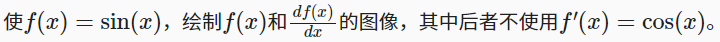

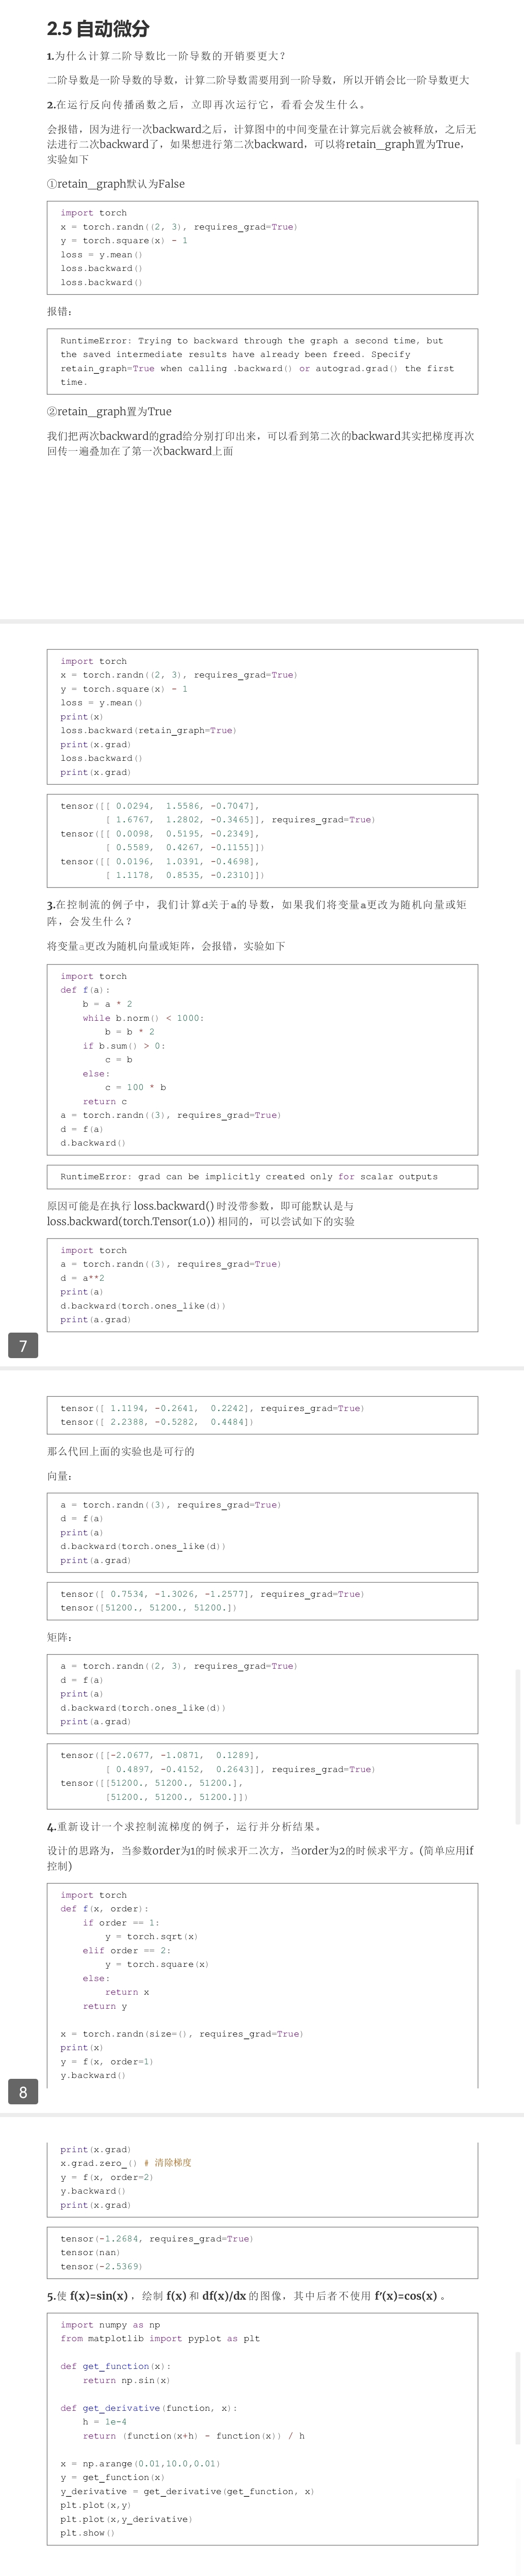